In [27]:
# ========================================
# Section 1: Importing Required Libraries
# ========================================

# Data handling and manipulation
import numpy as np
import pandas as pd
import os
import random

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing
import cv2
from PIL import Image

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Scikit-learn for evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


✅ Indexed 39209 images across 43 classes.
🧯 Corrupt/Unreadable: 0
📊 Class imbalance Gini index: 0.9635 (0 = fully concentrated, smaller is worse; ~uniform gives higher)


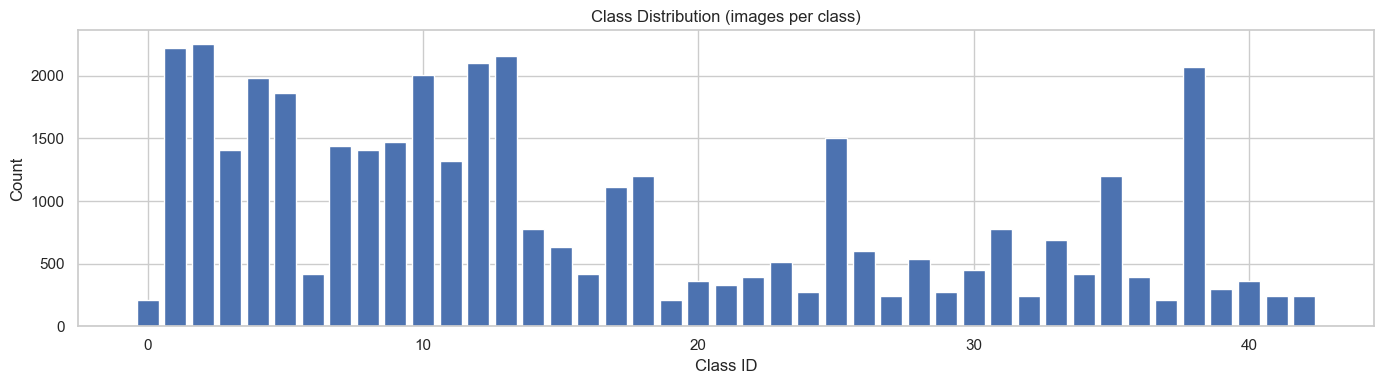

📐 Median size: 43x43 | Mean size: 50.8x50.3


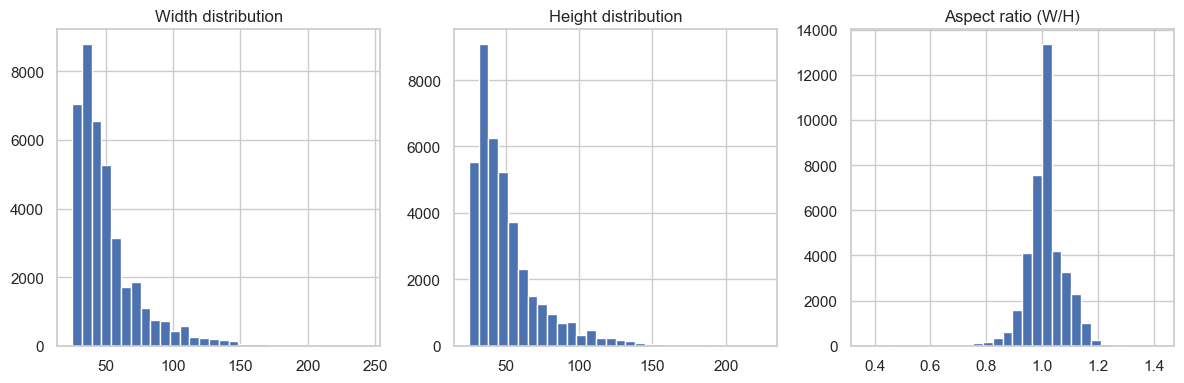

🎯 RGB mean: [0.3435 0.3201 0.3311] | RGB std: [0.2711 0.2621 0.2694]


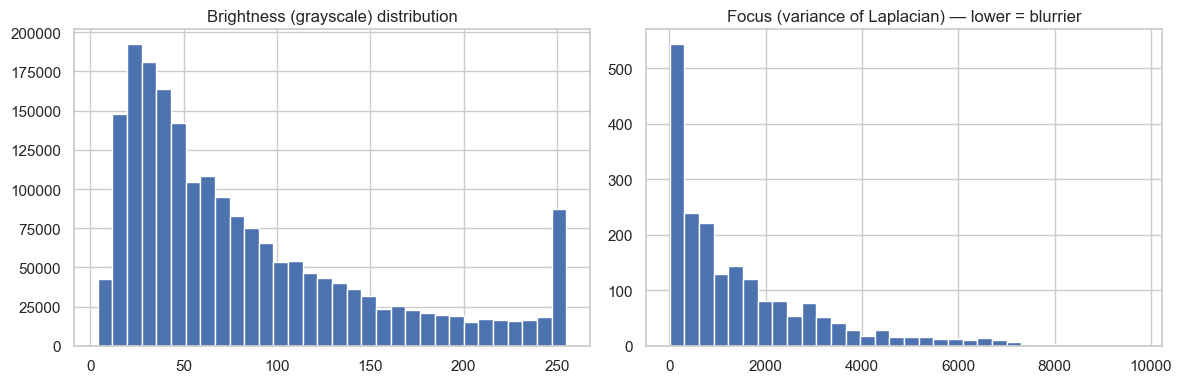

🧭 Potential duplicate groups (sample): 0 | images in groups: 0


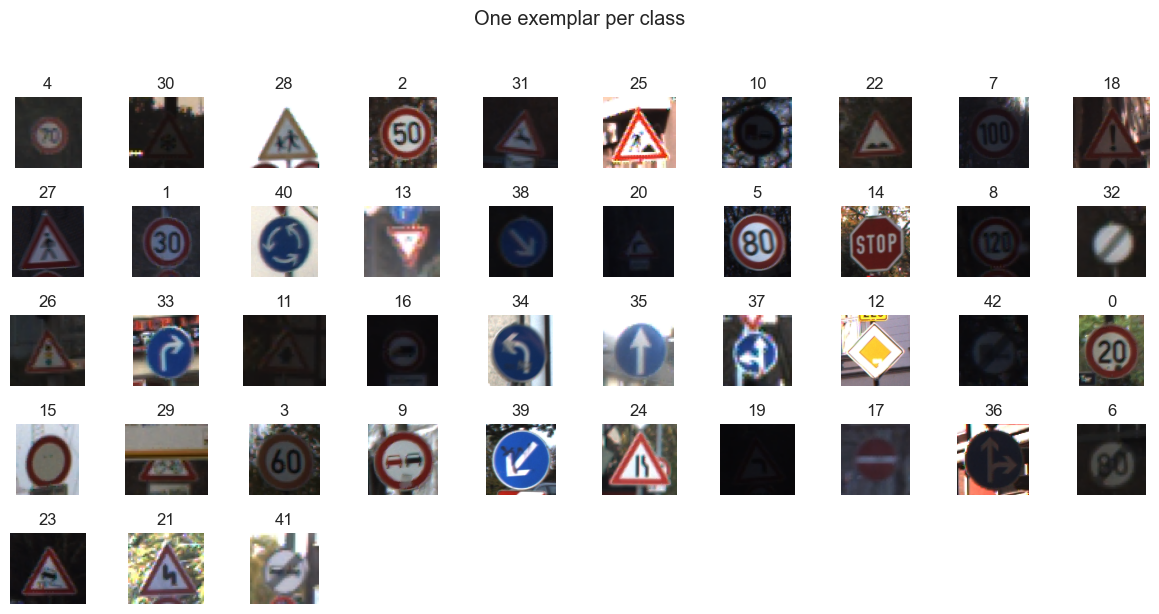

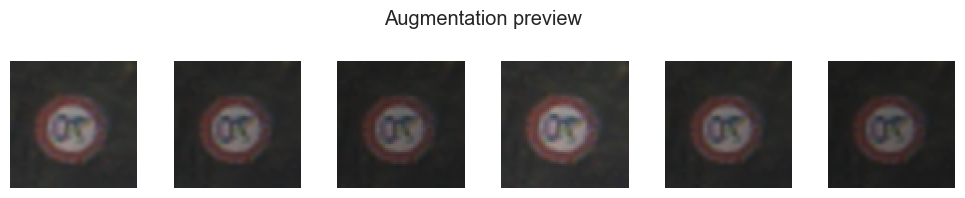

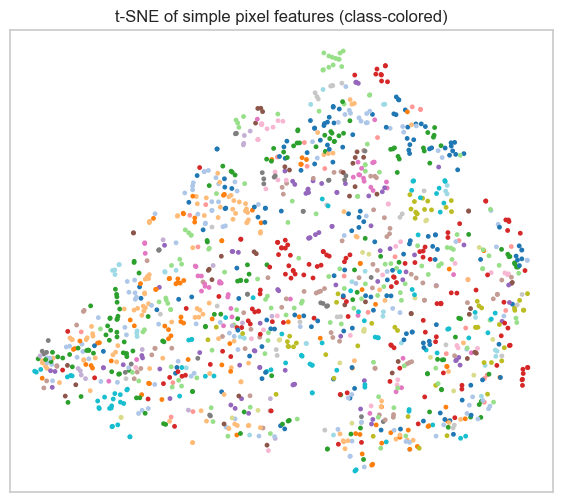

,total_images,num_classes,corrupt_removed,mean_width,mean_height,aspect_median,rgb_mean_r_g_b,rgb_std_r_g_b,gini_imbalance,dup_groups_in_sample
0,39209,43,0,50.83588,50.32893,1.0,"(0.3435, 0.3201, 0.3311)","(0.2711, 0.2621, 0.2694)",0.963515,0


In [29]:
# ============================================
# Section 2: Deep EDA for GTSRB (single cell)
# ============================================

# ----------- Imports used in this cell -----------
import os                              # work with file paths
import numpy as np                     # fast numeric ops
import pandas as pd                    # tabular summaries
from PIL import Image                  # robust image IO
import cv2                             # image ops (blur, edges)
import matplotlib.pyplot as plt        # plotting
from collections import Counter        # quick class counts
from hashlib import md5                # fast content hash
import itertools                       # small helpers
import random                          # sampling
from sklearn.manifold import TSNE      # 2D visual of features
# --------------------------------------------------

# ----------- Config & helpers -----------
DATA_DIR = "./input"                   # dataset root (you said it's in 'input' beside the notebook)
TRAIN_DIR = os.path.join(DATA_DIR, "Train")  # expected train folder structure: Train/<class_id>/*.png
SEED = 42                              # reproducibility seed
random.seed(SEED)                      # set python's rng
np.random.seed(SEED)                   # set numpy's rng

IMG_SIZE = (32, 32)                    # small, efficient size for stats/t-SNE (we'll use bigger later if needed)
SAMPLE_FOR_QUALITY = 2000              # cap computations for heavy stats to keep the cell fast
SAMPLE_FOR_TSNE = 1500                 # t-SNE cost grows ~O(n^2); keep modest
# ---------------------------------------

# ----------- Scan filesystem & build index -----------
image_paths = []                       # will store full image paths
labels = []                            # numeric labels parsed from directory names
for cls in sorted(os.listdir(TRAIN_DIR)):                  # iterate class folders in sorted order
    cls_path = os.path.join(TRAIN_DIR, cls)                # full path for a class directory
    if not os.path.isdir(cls_path):                        # skip non-dirs (just in case)
        continue                                           # continue to next item
    for fname in os.listdir(cls_path):                     # iterate images in class directory
        if fname.lower().endswith((".png", ".jpg", ".jpeg", ".ppm")):  # accept common image formats
            image_paths.append(os.path.join(cls_path, fname))          # push full image path
            labels.append(int(cls))                                    # folder name is label id

df = pd.DataFrame({"path": image_paths, "label": labels})  # build dataframe for convenience
df = df.sample(frac=1.0, random_state=SEED).reset_index(drop=True)     # shuffle for fair sampling
print(f"✅ Indexed {len(df)} images across {df['label'].nunique()} classes.")
# ------------------------------------------------------

# ----------- Integrity checks (readability + corrupt) -----------
bad_paths = []                                           # collect unreadable/corrupt files
widths, heights = [], []                                 # track native sizes for distribution
for p in df["path"].values:                              # iterate all paths
    try:
        with Image.open(p) as im:                        # try PIL open
            im.verify()                                  # check file integrity (no full decode)
        with Image.open(p) as im2:                       # reopen to get size safely
            w, h = im2.size                              # retrieve width, height
            widths.append(w)                             # store width
            heights.append(h)                            # store height
    except Exception as e:                               # if any error occurs
        bad_paths.append(p)                              # mark as bad

print(f"🧯 Corrupt/Unreadable: {len(bad_paths)}")
if bad_paths:                                            # if we found any corrupt files
    df = df[~df["path"].isin(bad_paths)].reset_index(drop=True)  # drop them from dataset
    print("   → Removed corrupt items from index.")
# --------------------------------------------------------------

# ----------- Class distribution + imbalance metric -----------
counts = Counter(df["label"].tolist())                   # count examples per class
class_ids = sorted(counts.keys())                        # sorted class ids
class_counts = np.array([counts[c] for c in class_ids])  # counts as array
probs = class_counts / class_counts.sum()                # class probabilities
gini = 1.0 - np.sum(probs**2)                            # Gini index: 0=perfectly balanced for single class? (lower is better)
print(f"📊 Class imbalance Gini index: {gini:.4f} (0 = fully concentrated, smaller is worse; ~uniform gives higher)")
# Plot distribution
plt.figure(figsize=(14,4))                               # make a wide plot
plt.bar(class_ids, class_counts)                         # bar chart of counts
plt.title("Class Distribution (images per class)")       # title
plt.xlabel("Class ID")                                   # x label
plt.ylabel("Count")                                      # y label
plt.tight_layout()                                       # avoid overlap
plt.show()                                               # render
# --------------------------------------------------------------

# ----------- Native size & aspect ratio distribution -----------
widths = np.array(widths)                                # to numpy
heights = np.array(heights)                              # to numpy
aspects = widths / heights                               # aspect ratio w/h
print(f"📐 Median size: {int(np.median(widths))}x{int(np.median(heights))} | "
      f"Mean size: {widths.mean():.1f}x{heights.mean():.1f}")
plt.figure(figsize=(12,4))                               # wide figure
plt.subplot(1,3,1)                                       # first panel
plt.hist(widths, bins=30)                                # histogram widths
plt.title("Width distribution")                          # title
plt.subplot(1,3,2)                                       # second panel
plt.hist(heights, bins=30)                               # histogram heights
plt.title("Height distribution")                         # title
plt.subplot(1,3,3)                                       # third panel
plt.hist(aspects, bins=30)                               # histogram aspect
plt.title("Aspect ratio (W/H)")                          # title
plt.tight_layout()                                       # layout fix
plt.show()                                               # render
# --------------------------------------------------------------

# ----------- Channel statistics (mean/std) -----------
# Sample a subset for speed while keeping class variety
sample_df = df.groupby("label", group_keys=False).apply(lambda g: g.head(max(1, SAMPLE_FOR_QUALITY // df['label'].nunique()))).reset_index(drop=True)  # balanced-ish sample
sample_df = sample_df.sample(min(len(sample_df), SAMPLE_FOR_QUALITY), random_state=SEED)  # cap size

sum_rgb = np.zeros(3, dtype=np.float64)                 # accumulative sum for mean
sum2_rgb = np.zeros(3, dtype=np.float64)                # accumulative sum of squares for std
pixel_count = 0                                         # total pixels counted

brightness_vals = []                                    # store grayscale brightness
blur_vals = []                                          # store laplacian variance (focus)

for p in sample_df["path"].values:                      # iterate sample
    img = Image.open(p).convert("RGB")                  # force RGB
    img = img.resize(IMG_SIZE, Image.BILINEAR)          # resize small for efficiency
    arr = np.asarray(img, dtype=np.float32) / 255.0     # to float [0,1]
    sum_rgb += arr.reshape(-1,3).sum(axis=0)            # accumulate channel sums
    sum2_rgb += (arr.reshape(-1,3)**2).sum(axis=0)      # accumulate squared sums
    pixel_count += arr.shape[0]*arr.shape[1]            # add pixel count

    gray = cv2.cvtColor((arr*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)  # compute grayscale
    brightness_vals.extend(gray.flatten().tolist())     # extend brightness values
    
    lap = cv2.Laplacian(gray, cv2.CV_64F)               # Laplacian for focus
    blur_vals.append(lap.var())                         # variance of laplacian → blur score

mean_rgb = (sum_rgb / pixel_count)                      # per-channel mean
std_rgb  = np.sqrt((sum2_rgb / pixel_count) - mean_rgb**2)  # per-channel std (population)
print(f"🎯 RGB mean: {mean_rgb.round(4)} | RGB std: {std_rgb.round(4)}")

plt.figure(figsize=(12,4))                              # multi-plot
plt.subplot(1,2,1)                                      # left panel
plt.hist(brightness_vals, bins=32)                      # brightness hist
plt.title("Brightness (grayscale) distribution")        # title
plt.subplot(1,2,2)                                      # right panel
plt.hist(blur_vals, bins=32)                            # blur hist
plt.title("Focus (variance of Laplacian) — lower = blurrier") # title
plt.tight_layout()                                      # layout fix
plt.show()                                              # render
# --------------------------------------------------------------

# ----------- Quick duplicate check (perceptual-ish) -----------
# We'll hash resized grayscale images; exact dupes will collide, near-dupes often cluster.
def quick_phash(path, size=16):                         # small hash function
    try:
        im = Image.open(path).convert("L").resize((size, size), Image.BILINEAR)  # grayscale small
        arr = np.asarray(im, dtype=np.float32)                                    # to numpy
        arr = (arr - arr.mean()) / (arr.std() + 1e-6)                             # normalize
        return md5(arr.tobytes()).hexdigest()                                     # md5 of bytes
    except:
        return None                                                                # unreadable guard

hashes = sample_df["path"].map(quick_phash)             # compute hash for sample
dup_counts = Counter(hashes.dropna())                   # count hashes
num_dupe_buckets = sum(1 for k,v in dup_counts.items() if v > 1)  # buckets with >1 item
num_dupe_images = sum(v for v in dup_counts.values() if v > 1)    # total images in dup buckets
print(f"🧭 Potential duplicate groups (sample): {num_dupe_buckets} | images in groups: {num_dupe_images}")
# --------------------------------------------------------------

# ----------- One exemplar per class (visual sanity check) -----------
exemplars = df.groupby("label").head(1)                 # first image per class
n_classes = exemplars["label"].nunique()                # number of classes
cols = 10                                               # grid columns
rows = int(np.ceil(n_classes / cols))                   # grid rows
plt.figure(figsize=(cols*1.2, rows*1.2))                # figure size proportional to grid
for i, (_, row) in enumerate(exemplars.iterrows(), 1):  # iterate exemplars
    img = Image.open(row.path).convert("RGB")           # open image
    plt.subplot(rows, cols, i)                          # pick subplot
    plt.imshow(img)                                     # show
    plt.axis('off')                                     # hide axes
    plt.title(row.label)                                # show label
plt.suptitle("One exemplar per class", y=1.02)          # grid title
plt.tight_layout()                                      # layout
plt.show()                                              # render
# --------------------------------------------------------------

# ----------- Augmentation preview (what we'll do in training) -----------
def augment_preview(path, k=6):                         # preview function
    img = Image.open(path).convert("RGB")               # open rgb
    base = np.asarray(img.resize((64,64)))              # resize moderately for display
    fig = plt.figure(figsize=(10,2))                    # horizontal strip
    for i in range(k):                                  # generate k variants
        aug = base.copy()                               # copy base
        # simple random transforms; training will use stronger ImageDataGenerator
        if random.random() < 0.7:                       # random flip
            aug = np.fliplr(aug)                        # horizontal flip
        if random.random() < 0.7:                       # random rotate small
            M = cv2.getRotationMatrix2D((32,32), random.uniform(-15,15), 1.0)  # rotation matrix
            aug = cv2.warpAffine(aug, M, (64,64), borderMode=cv2.BORDER_REFLECT_101)  # apply rotate
        if random.random() < 0.7:                       # random brightness jitter
            factor = random.uniform(0.7, 1.3)           # brightness scale
            aug = np.clip(aug * factor, 0, 255).astype(np.uint8)  # apply
        ax = fig.add_subplot(1,k,i+1)                   # subplot
        ax.imshow(aug)                                   # show
        ax.axis('off')                                   # no axes
    plt.suptitle("Augmentation preview")                 # title
    plt.tight_layout()                                   # layout
    plt.show()                                           # render

augment_preview(df.iloc[0].path, k=6)                   # preview on first image
# --------------------------------------------------------------

# ----------- Quick separability check via t-SNE on simple features -----------
# We'll use tiny 32x32 RGB flattened pixels as features (not great, but good to gauge separability quickly).
tsne_df = df.sample(min(len(df), SAMPLE_FOR_TSNE), random_state=SEED)  # sample for speed
X = []                                              # feature matrix
y = []                                              # labels
for p, lab in zip(tsne_df["path"].values, tsne_df["label"].values):    # iterate sample
    arr = np.asarray(Image.open(p).convert("RGB").resize(IMG_SIZE), dtype=np.float32) / 255.0  # 32x32x3
    X.append(arr.flatten())                         # flatten to 3072-dim vector
    y.append(lab)                                   # label
X = np.stack(X, axis=0)                             # to (n, d)
y = np.array(y)                                     # to array

tsne = TSNE(n_components=2, random_state=SEED, init="pca", learning_rate="auto", perplexity=30)  # t-SNE config
X2 = tsne.fit_transform(X)                          # embed into 2D
plt.figure(figsize=(7,6))                           # figure
scatter = plt.scatter(X2[:,0], X2[:,1], c=y, s=6, cmap="tab20")  # colored by class
plt.title("t-SNE of simple pixel features (class-colored)")      # title
plt.xticks([]); plt.yticks([])                      # tidy axes
plt.show()                                          # render
# --------------------------------------------------------------

# ----------- Final EDA summary table -----------
summary = {
    "total_images": [len(df)],                       # count after integrity cleaning
    "num_classes": [df["label"].nunique()],          # distinct labels
    "corrupt_removed": [len(bad_paths)],             # removed corrupt files
    "mean_width": [float(np.mean(widths))],          # avg width
    "mean_height": [float(np.mean(heights))],        # avg height
    "aspect_median": [float(np.median(aspects))],    # median aspect ratio
    "rgb_mean_r_g_b": [tuple(mean_rgb.round(4))],    # rgb means
    "rgb_std_r_g_b": [tuple(std_rgb.round(4))],      # rgb stds
    "gini_imbalance": [float(gini)],                 # imbalance metric
    "dup_groups_in_sample": [int(num_dupe_buckets)], # potential dup clusters in sample
}
summary_df = pd.DataFrame(summary)                   # make table
display(summary_df)                                  # show neat summary
# --------------------------------------------------------------


In [31]:
# ========================================
# Section 2.5: Dataset Loading
# ========================================

import glob

# Path to the dataset
# Assuming structure: input/Train/{class_id}/*.ppm or *.png
train_path = "input/Train"

# Create list for file paths and labels
image_paths = []
labels = []

# Loop through each class folder
for class_id in os.listdir(train_path):
    class_folder = os.path.join(train_path, class_id)
    if os.path.isdir(class_folder):
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            image_paths.append(img_path)
            labels.append(int(class_id))  # Convert folder name to integer label

# Create DataFrame
df = pd.DataFrame({
    "image": image_paths,
    "label": labels
})

print("✅ Dataset loaded successfully!")
print(f"Total samples: {len(df)}")
print(f"Number of classes: {df['label'].nunique()}")

# Shuffle dataset for randomness
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()


✅ Dataset loaded successfully!
Total samples: 39209
Number of classes: 43


,image,label
0,input/Train\4\00004_00007_00004.png,4
1,input/Train\30\00030_00000_00010.png,30
2,input/Train\28\00028_00008_00000.png,28
3,input/Train\2\00002_00039_00021.png,2
4,input/Train\31\00031_00005_00015.png,31


In [32]:
# ========================================
# Section 3: Data Preprocessing
# ========================================

from tensorflow.keras.utils import to_categorical

# Fixed image size for CNN
IMG_HEIGHT, IMG_WIDTH = 30, 30

# ========================
# 1. Resize & Normalize Images
# ========================
X_data = []
y_data = []

for img_path, label in zip(df["image"], df["label"]):
    # Read the image
    img = cv2.imread(img_path)
    # Convert BGR (OpenCV default) to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize image
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    # Normalize to range [0,1]
    img = img / 255.0
    X_data.append(img)
    y_data.append(label)

# Convert lists to numpy arrays
X_data = np.array(X_data)
y_data = np.array(y_data)

print("✅ Image preprocessing done!")
print(f"Shape of X_data: {X_data.shape}")
print(f"Shape of y_data: {y_data.shape}")

# ========================
# 2. Train-Test-Validation Split
# ========================
# First split into train+val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42, stratify=y_data
)

# Then split train into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

# ========================
# 3. One-hot Encode Labels
# ========================
num_classes = len(np.unique(y_data))
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print("✅ Labels one-hot encoded!")

# ========================
# 4. Data Augmentation Generator
# ========================
train_datagen = ImageDataGenerator(
    rotation_range=10,        # Random rotation
    zoom_range=0.1,           # Random zoom
    width_shift_range=0.1,    # Horizontal shift
    height_shift_range=0.1,   # Vertical shift
    shear_range=0.1,          # Shearing
    horizontal_flip=False,    # Don't flip horizontally (traffic signs are fixed)
    fill_mode="nearest"       # Fill empty pixels
)

val_datagen = ImageDataGenerator()  # No augmentation for validation

# Create generators
train_generator = train_datagen.flow(X_train, y_train_cat, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val_cat, batch_size=32)

print("✅ Data generators created successfully!")


✅ Image preprocessing done!
Shape of X_data: (39209, 30, 30, 3)
Shape of y_data: (39209,)
Training samples: 25093
Validation samples: 6274
Test samples: 7842
✅ Labels one-hot encoded!
✅ Data generators created successfully!


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,251 (946.29 KB)

 Trainable params: 242,251 (946.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
784/784 ━━━━━━━━━━━━━━━━━━━━ 68s 78ms/step - accuracy: 0.3455 - loss: 2.2734 - val_accuracy: 0.7932 - val_loss: 0.7078
Epoch 2/30
784/784 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5625 - loss: 1.3629 - val_accuracy: 0.8112 - val_loss: 0.6850
Epoch 3/30
784/784 ━━━━━━━━━━━━━━━━━━━━ 56s 72ms/step - accuracy: 0.7191 - loss: 0.8923 - val_accuracy: 0.9225 - val_loss: 0.2488
Epoch 4/30
784/784 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8438 - loss: 0.8773 - val_accuracy: 0.9169 - val_loss: 0.2589
Epoch 5/30
784/784 ━━━━━━━━━━━━━━━━━━━━ 54s 69ms/step - accuracy: 0.8328 - loss: 0.5318 - val_accuracy: 0.9635 - val_loss: 0.1403
Epoch 6/30
784/784 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7812 - loss: 0.5956 - val_accuracy: 0.9673 - val_loss: 0.1305
Epoch 7/30
784/784 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step - accuracy: 0.8766 - loss: 0.3916 - val_accuracy: 0.9777 - val_loss: 0.0749
Epoch 8/30
784/784 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8438 - loss: 0.5982 - val_accu

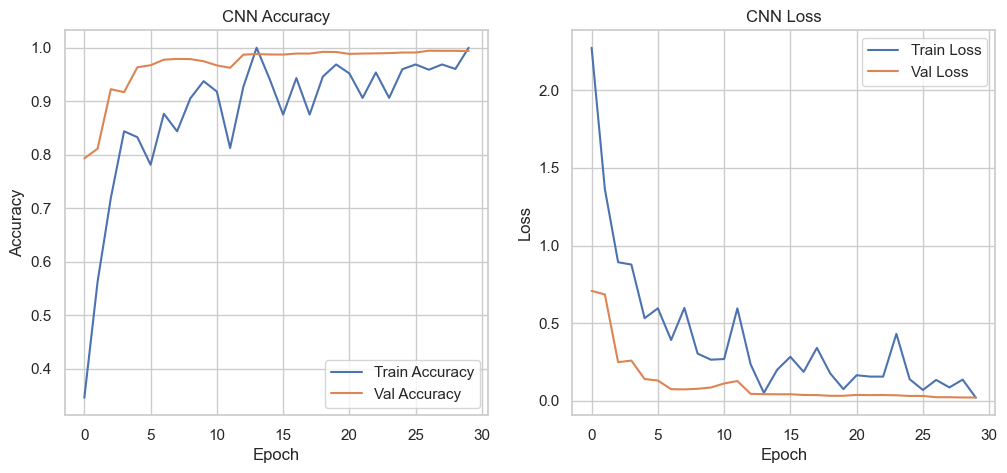

In [33]:
# ========================================
# Section 4: Custom CNN Model
# ========================================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# ========================
# 1. Model Architecture
# ========================
model_cnn = Sequential()

# First Convolutional Block
model_cnn.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model_cnn.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))

# Second Convolutional Block
model_cnn.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model_cnn.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))

# Fully Connected Layers
model_cnn.add(Flatten())
model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(num_classes, activation='softmax'))

# ========================
# 2. Compile the Model
# ========================
model_cnn.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model_cnn.summary()

# ========================
# 3. Train the Model
# ========================
history_cnn = model_cnn.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=30,
    validation_data=val_generator,
    validation_steps=len(X_val) // 32
)

# ========================
# 4. Plot Accuracy & Loss
# ========================
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title('CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


✅ CNN Test Accuracy: 99.57%
Test Loss: 0.0152
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99       444
           2       0.99      1.00      1.00       450
           3       0.99      0.99      0.99       282
           4       0.99      1.00      1.00       396
           5       0.99      0.99      0.99       372
           6       0.99      1.00      0.99        84
           7       1.00      1.00      1.00       288
           8       1.00      1.00      1.00       282
           9       1.00      1.00      1.00       294
          10       1.00      1.00      1.00       402
          11       1.00      1.00      1.00       264
          12       1.00      1.00      1.00       420
          13       1.00      1.00      1.00       432
          14       1.00      0.99      1.00       156
          15       1.

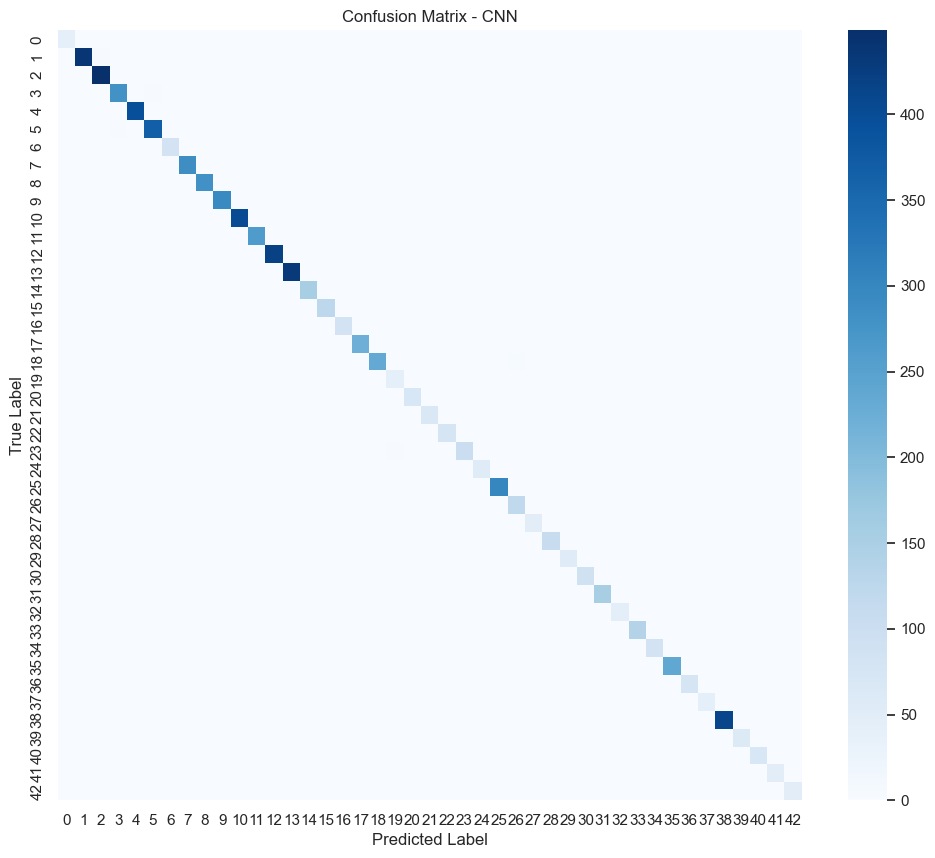

In [34]:
# ========================================
# Section 5: Model Evaluation
# ========================================

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ========================
# 1. Evaluate on Test Data
# ========================
test_loss, test_accuracy = model_cnn.evaluate(X_test, y_test_cat, verbose=0)
print(f"✅ CNN Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# ========================
# 2. Predictions
# ========================
y_pred_probs = model_cnn.predict(X_test)             # Probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)     # Predicted class index
y_true_classes = np.argmax(y_test_cat, axis=1)       # True class index

# ========================
# 3. Classification Report
# ========================
print("\n📊 Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# ========================
# 4. Confusion Matrix
# ========================
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix - CNN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 1, 1, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,166,763 (76.93 MB)

 Trainable params: 142,379 (556.17 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/15
785/785 ━━━━━━━━━━━━━━━━━━━━ 804s 1s/step - accuracy: 0.1708 - loss: 3.1091 - val_accuracy: 0.3011 - val_loss: 2.5827
Epoch 2/15
785/785 ━━━━━━━━━━━━━━━━━━━━ 602s 765ms/step - accuracy: 0.2844 - loss: 2.5306 - val_accuracy: 0.3734 - val_loss: 2.2549
Epoch 3/15
785/785 ━━━━━━━━━━━━━━━━━━━━ 676s 834ms/step - accuracy: 0.3345 - loss: 2.2832 - val_accuracy: 0.4064 - val_loss: 2.0773
Epoch 4/15
785/785 ━━━━━━━━━━━━━━━━━━━━ 786s 1s/step - accuracy: 0.3717 - loss: 2.1270 - val_accuracy: 0.4385 - val_loss: 1.9564
Epoch 5/15
785/785 ━━━━━━━━━━━━━━━━━━━━ 658s 839ms/step - accuracy: 0.4052 - loss: 2.0106 - val_accuracy: 0.4681 - val_loss: 1.8610
Epoch 6/15
785/785 ━━━━━━━━━━━━━━━━━━━━ 612s 780ms/step - accuracy: 0.4239 - loss: 1.9299 - val_accuracy: 0.4855 - val_loss: 1.7838
Epoch 7/15
785/785 ━━━━━━━━━━━━━━━━━━━━ 602s 766ms/step - accuracy: 0.4466 - loss: 1.8474 - val_accuracy: 0.5043 - val_loss: 1.7135
Epoch 8/15
785/785 ━━━━━━━━━━━━━━━━━━━━ 34023s 43s/step - accuracy: 0.4669 - loss:

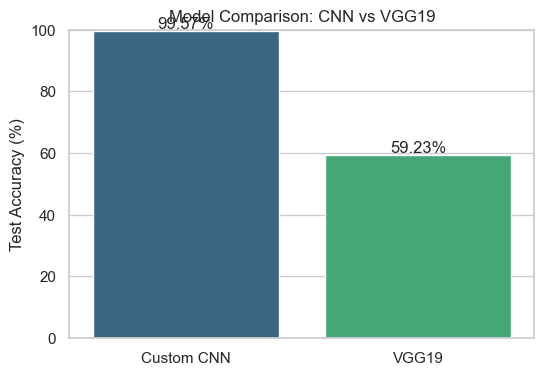

In [37]:
# ========================================
# Section 6: Model Comparison (CNN vs VGG19) – Fixed for Image Size
# ========================================

from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# ========================
# 1. Resize Data for VGG19
# ========================
IMG_HEIGHT_VGG = 48
IMG_WIDTH_VGG = 48

# Resize using TensorFlow's efficient resize
X_train_vgg = np.array([tf.image.resize(img, (IMG_HEIGHT_VGG, IMG_WIDTH_VGG)).numpy() for img in X_train])
X_val_vgg = np.array([tf.image.resize(img, (IMG_HEIGHT_VGG, IMG_WIDTH_VGG)).numpy() for img in X_val])
X_test_vgg = np.array([tf.image.resize(img, (IMG_HEIGHT_VGG, IMG_WIDTH_VGG)).numpy() for img in X_test])

# ========================
# 2. Build VGG19 Model
# ========================
vgg_base = VGG19(weights='imagenet', include_top=False,
                 input_shape=(IMG_HEIGHT_VGG, IMG_WIDTH_VGG, 3))

# Freeze pretrained layers
for layer in vgg_base.layers:
    layer.trainable = False

# Create model
vgg_model = Sequential([
    vgg_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile
vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

vgg_model.summary()

# ========================
# 3. Train VGG19 Model
# ========================
history_vgg = vgg_model.fit(
    X_train_vgg, y_train_cat,
    validation_data=(X_val_vgg, y_val_cat),
    epochs=15,
    batch_size=32
)

# ========================
# 4. Evaluate both models
# ========================
cnn_test_loss, cnn_test_acc = model_cnn.evaluate(X_test, y_test_cat, verbose=0)
vgg_test_loss, vgg_test_acc = vgg_model.evaluate(X_test_vgg, y_test_cat, verbose=0)

print(f"✅ CNN Test Accuracy: {cnn_test_acc * 100:.2f}%")
print(f"✅ VGG19 Test Accuracy: {vgg_test_acc * 100:.2f}%")

# ========================
# 5. Compare visually
# ========================
models = ['Custom CNN', 'VGG19']
accuracies = [cnn_test_acc * 100, vgg_test_acc * 100]

plt.figure(figsize=(6, 4))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.ylabel("Test Accuracy (%)")
plt.title("Model Comparison: CNN vs VGG19")
plt.ylim(0, 100)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', fontsize=12)
plt.show()


In [38]:
# ========================================
# Section 7: Save & Load Models
# ========================================

import os

# Create directory to store models
os.makedirs("saved_models", exist_ok=True)

# ========================
# 1. Save the models
# ========================
cnn_model_path = "saved_models/cnn_gtsrb.h5"
vgg_model_path = "saved_models/vgg19_gtsrb.h5"

model_cnn.save(cnn_model_path)
vgg_model.save(vgg_model_path)

print(f"✅ CNN model saved at: {cnn_model_path}")
print(f"✅ VGG19 model saved at: {vgg_model_path}")

# ========================
# 2. Load the models
# ========================
from tensorflow.keras.models import load_model

loaded_cnn = load_model(cnn_model_path)
loaded_vgg = load_model(vgg_model_path)

print("✅ Models loaded successfully!")

# ========================
# 3. Quick test to confirm loaded models work
# ========================
loaded_cnn_loss, loaded_cnn_acc = loaded_cnn.evaluate(X_test, y_test_cat, verbose=0)
loaded_vgg_loss, loaded_vgg_acc = loaded_vgg.evaluate(X_test_vgg, y_test_cat, verbose=0)

print(f"📂 Loaded CNN Accuracy: {loaded_cnn_acc * 100:.2f}%")
print(f"📂 Loaded VGG19 Accuracy: {loaded_vgg_acc * 100:.2f}%")


✅ CNN model saved at: saved_models/cnn_gtsrb.h5
✅ VGG19 model saved at: saved_models/vgg19_gtsrb.h5


✅ Models loaded successfully!
📂 Loaded CNN Accuracy: 99.57%
📂 Loaded VGG19 Accuracy: 59.23%
